In [1]:
shape = (150, 150, 3)
image_size = 150
path = "./Images/"

In [2]:
import os
import glob as gb
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm


def read_images_from_directory(
    folder_path,
    desc,
):
    images = []
    labels = []

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + "/" + folder + "/*.jpg"))

        for file in tqdm(files, desc=desc + " in " + folder):
            image = plt.imread(file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(folder)
    return images, labels

In [3]:
images, labels = read_images_from_directory(path, "Loading Data")

Loading Data in pituitary_tumor: 100%|██████████| 4504/4504 [00:19<00:00, 225.95it/s]


In [4]:
from sklearn.preprocessing import LabelBinarizer

x_data = np.array(images)
lb = LabelBinarizer()
y_data = lb.fit_transform(labels)

In [5]:
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42
)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential


from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D

In [7]:
densenet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
    pooling="avg",
)

In [8]:
for layer in densenet.layers:
    layer.trainable = False

model = densenet.output
model = Dense(512, activation="relu")(model)
model = Dense(256, activation="relu")(model)
pred = Dense(4, activation="softmax")(model)
model = Model(inputs=densenet.input, outputs=pred)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [11]:
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=earlystop,
)

Epoch 1/50
353/353 [==============================] - 69s 136ms/step - loss: 0.9059 - accuracy: 0.6822 - val_loss: 0.5904 - val_accuracy: 0.7630
Epoch 2/50
353/353 [==============================] - 38s 108ms/step - loss: 0.5510 - accuracy: 0.7830 - val_loss: 0.5021 - val_accuracy: 0.8037
Epoch 3/50
353/353 [==============================] - 39s 111ms/step - loss: 0.4552 - accuracy: 0.8256 - val_loss: 0.4937 - val_accuracy: 0.8143
Epoch 4/50
353/353 [==============================] - 39s 111ms/step - loss: 0.4294 - accuracy: 0.8342 - val_loss: 0.4219 - val_accuracy: 0.8361
Epoch 5/50
353/353 [==============================] - 39s 110ms/step - loss: 0.3919 - accuracy: 0.8505 - val_loss: 0.4535 - val_accuracy: 0.8284
Epoch 6/50
353/353 [==============================] - 39s 110ms/step - loss: 0.3352 - accuracy: 0.8707 - val_loss: 0.3823 - val_accuracy: 0.8616
Epoch 7/50
353/353 [==============================] - 39s 110ms/step - loss: 0.3110 - accuracy: 0.8815 - val_loss: 0.3828 - val_ac

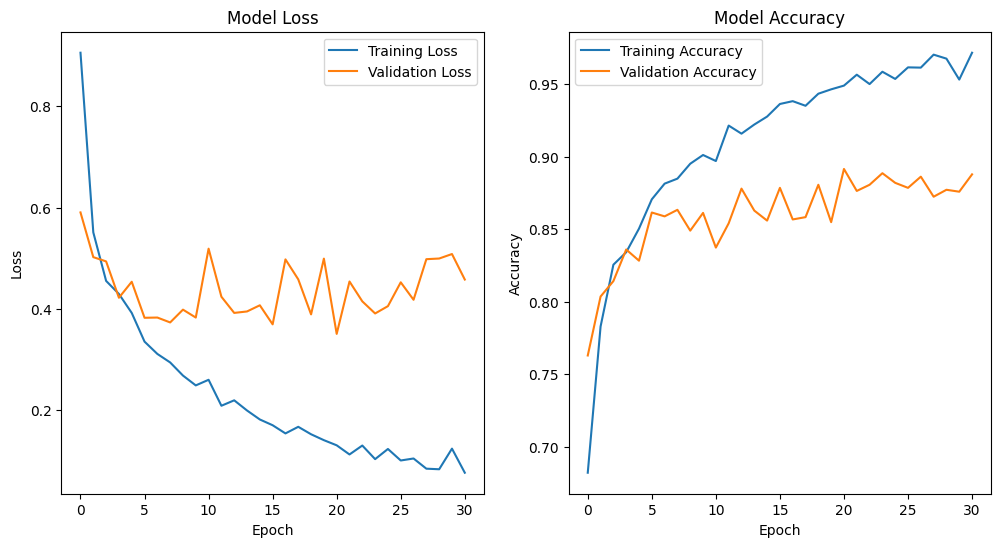

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 11s 89ms/step - loss: 0.3504 - accuracy: 0.8945
Test accuracy: 0.8945270776748657
Test loss: 0.35037466883659363


In [14]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 14s 86ms/step


In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [16]:
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Accuracy: 0.8945270988310308
Precision: 0.8972914012674064
Recall: 0.8945270988310308
F1 Score: 0.8949927837420768


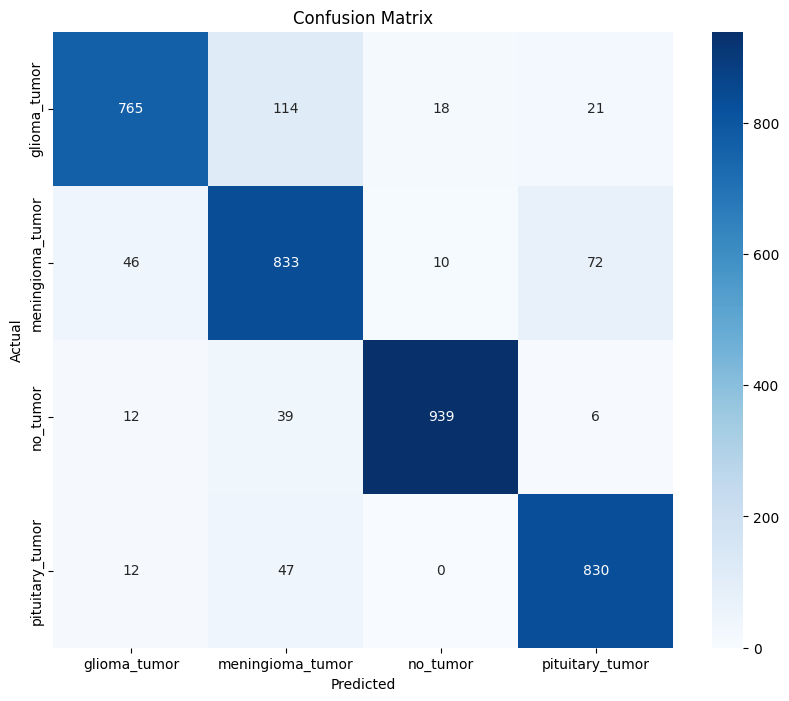

In [17]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [58]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "DenseNet201_01(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\DenseNet201_01(150x150).h5
